In [1]:
# importing some libraries we need in this part
import scipy.io
import numpy as np
import os
from collections import defaultdict, Counter
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from cmath import pi
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy.signal import stft
from scipy import signal
import numpy as np
from scipy.fft import fft, fftfreq
from scipy import signal
from scipy.signal import savgol_filter
import pywt  # For wavelet transform

In [2]:
import pickle

# Load the dataset
with open('Data/trainset.pickle', 'rb') as handle:
    trainset = pickle.load(handle)

# Select the CSI series and ground truth
CSI = trainset['CSI'][1]
groundtruth = trainset['groundtruth'][1]  # Ground truth for the selected experiment
experiment_name = trainset['ex_name'][1][:-4]
print("The name of this experiment: ", experiment_name)

CSI_amplitude = np.abs(trainset['CSI'][1]) 


# Select the specific subcarrier and link
selected_subcarrier = 15
selected_Rx = 0
selected_Tx = 1
csi_amplitude = CSI_amplitude[:, selected_subcarrier, selected_Rx, selected_Tx]

# Define sampling rate
sampling_rate = 100  # Hz


The name of this experiment:  breath_bpm15_ax200_cbw20_fs100_2x2_1_220928_164837


In [3]:
from scipy import signal
from scipy.signal import savgol_filter
import pywt
import numpy as np
from pykalman import KalmanFilter

def preprocess_with_filter(CSI, filter_type):
    CSI_amplitude = np.abs(CSI)
    CSI_phase = np.angle(CSI)

    # Check data length
    if CSI_amplitude.shape[0] < 10:
        raise ValueError("Insufficient length of CSI data for filtering.")

    if filter_type == "Butterworth":
        b, a = signal.butter(2, [0.002, 0.005], 'bandpass')  # Optimized order and cutoff
        filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)

    elif filter_type == "Savitzky-Golay":
        filtered_amplitude = savgol_filter(CSI_amplitude, window_length=31, polyorder=3, axis=0)  # Optimized parameters

    elif filter_type == "Wavelet":
        filtered_amplitude = np.empty_like(CSI_amplitude)
        for i in range(CSI_amplitude.shape[1]):
            coeffs = pywt.wavedec(CSI_amplitude[:, i], wavelet='db4', level=3)
            threshold = 0.2 * np.max(coeffs[0])  # Optimized threshold
            coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
            filtered_amplitude[:, i] = pywt.waverec(coeffs, wavelet='db4')

    elif filter_type == "Hampel":
        from statsmodels.robust.scale import mad
        window_size = 5
        threshold = 3
        filtered_amplitude = signal.medfilt(CSI_amplitude, kernel_size=window_size)
        # Refine filtering using mad-based thresholding
        filtered_amplitude = np.clip(filtered_amplitude, -threshold * mad(filtered_amplitude), threshold * mad(filtered_amplitude))

    elif filter_type == "Kalman":
        kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
        filtered_amplitude = np.empty_like(CSI_amplitude)
        for i in range(CSI_amplitude.shape[1]):
            state_means, _ = kf.filter(CSI_amplitude[:, i])
            filtered_amplitude[:, i] = state_means.ravel()

    elif filter_type == "Bandpass":
        b, a = signal.butter(4, [0.002, 0.005], btype='bandpass')  # Higher order for sharper cutoff
        filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)

    else:
        raise ValueError("Unsupported filter type!")

    return filtered_amplitude, CSI_phase

# Apply preprocessing with multiple filters
filters = ["Butterworth", "Savitzky-Golay", "Wavelet", "Hampel", "Kalman", "Bandpass"]
processed_data = {}

for f in filters:
    try:
        print(f"Processing with {f} filter...")
        processed_amplitude, processed_phase = preprocess_with_filter(CSI, f)
        processed_data[f] = (processed_amplitude, processed_phase)
    except Exception as e:
        print(f"Error during preprocessing with {f}: {e}")


Processing with Butterworth filter...
Processing with Savitzky-Golay filter...
Processing with Wavelet filter...


/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Processing with Hampel filter...


/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/scipy/signal/_signaltools.py:1551: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


Processing with Kalman filter...
Error during preprocessing with Kalman: shapes (1,1) and (2,2) not aligned: 1 (dim 1) != 2 (dim 0)
Processing with Bandpass filter...


In [4]:
features = {}

for f in filters:
    if f not in processed_data:
        continue
    
    processed_amplitude, _ = processed_data[f]
    selected_subcarrier = 15
    selected_Rx, selected_Tx = 0, 1
    
    # Select amplitude for the chosen subcarrier and antenna pair
    selected_component = processed_amplitude[:, selected_subcarrier, selected_Rx, selected_Tx]
    
    # Apply FFT
    feature = np.fft.fft(selected_component)
    features[f] = feature
    print(f"Feature extracted for {f} filter.")


Feature extracted for Butterworth filter.
Feature extracted for Savitzky-Golay filter.
Feature extracted for Wavelet filter.
Feature extracted for Hampel filter.
Feature extracted for Bandpass filter.


In [5]:
results = {}

for f in filters:
    if f not in features:
        continue
    
    feature = features[f]
    
    # Peak detection
    max_value = np.max(np.abs(feature))
    arg_max = np.argmax(np.abs(feature))
    
    # Calculate estimated breath rate
    sampling_frequency = 100  # Hz
    frequency = arg_max * (sampling_frequency / len(feature))
    estimated_breath_rate = frequency * 60  # BPM
    
    results[f] = estimated_breath_rate
    print(f"{f} Filter - Estimated Breathing Rate: {estimated_breath_rate:.2f} BPM")


Butterworth Filter - Estimated Breathing Rate: 5985.00 BPM
Savitzky-Golay Filter - Estimated Breathing Rate: 0.00 BPM
Wavelet Filter - Estimated Breathing Rate: 0.00 BPM
Hampel Filter - Estimated Breathing Rate: 0.00 BPM
Bandpass Filter - Estimated Breathing Rate: 7.00 BPM


In [6]:
def result_visualization(groundtruth, final_result):
    """
    Visualize the comparison between ground truth and estimated breath rate series.
    """
    plt.figure(figsize=(12, 6), dpi=300)
    plt.plot(groundtruth, label='Ground Truth', color='blue', linewidth=2)
    plt.plot(final_result, label='Estimated Breath Rate', color='red', linestyle='--', linewidth=2)

    # Adding annotations for the last predicted and ground truth values
    plt.annotate(f'Predicted: {final_result[-1]:.2f} BPM',
                 xy=(len(final_result)-1, final_result[-1]),
                 xytext=(len(final_result)-1, final_result[-1] + 2),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=12)
    
    plt.annotate(f'Ground Truth: {groundtruth[-1]:.2f} BPM',
                 xy=(len(groundtruth)-1, groundtruth[-1]),
                 xytext=(len(groundtruth)-1, groundtruth[-1] + 2),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=12)
    
    plt.title('Estimated Breath Rate vs Ground Truth', fontsize=16)
    plt.xlabel('Samples', fontsize=14)
    plt.ylabel('Breath Rate (BPM)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Save the figure
    output_dir = "Visualization/"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, 'breath_rate_comparison_with_annotations.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Visualization saved at: {output_path}")


In [7]:
def MSE(final_result, groundtruth):
    """
    Calculate Mean Squared Error (MSE) between the estimated and ground truth series.
    """
    re = np.array(final_result)  # Convert list to numpy array
    gr = np.array(groundtruth)  # Convert ground truth to numpy array
    return np.mean((re - gr) ** 2)  # Calculate and return the mean squared error


Butterworth Filter - MSE: 35638615.93


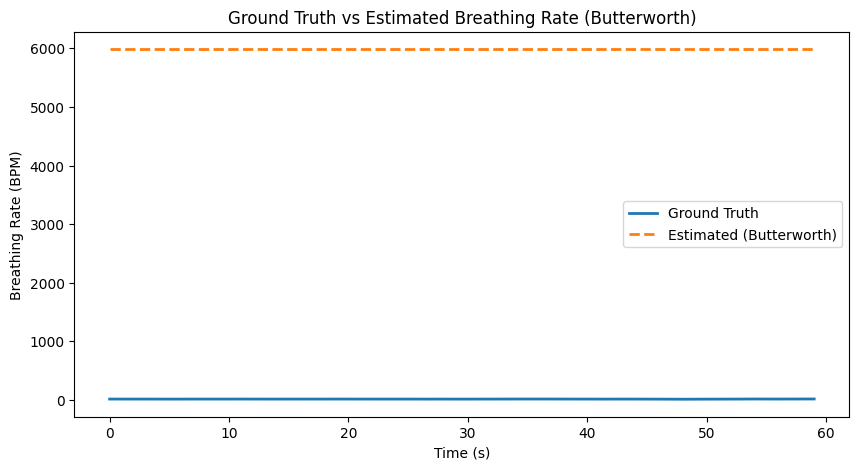

Savitzky-Golay Filter - MSE: 231.24


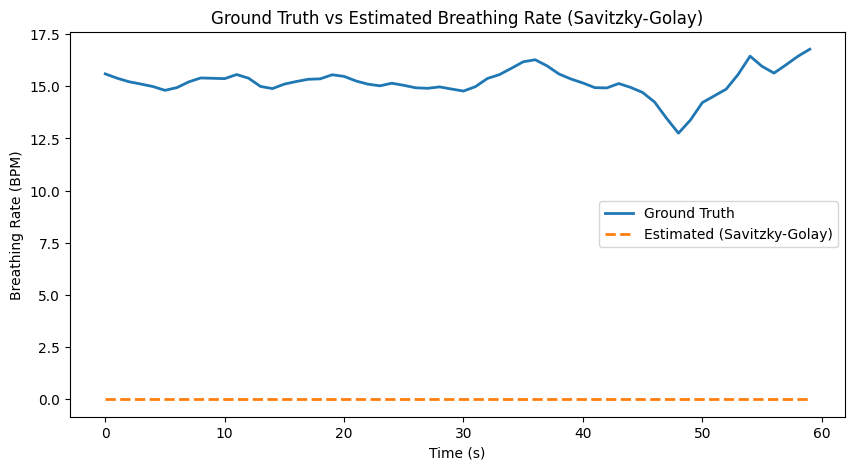

Wavelet Filter - MSE: 231.24


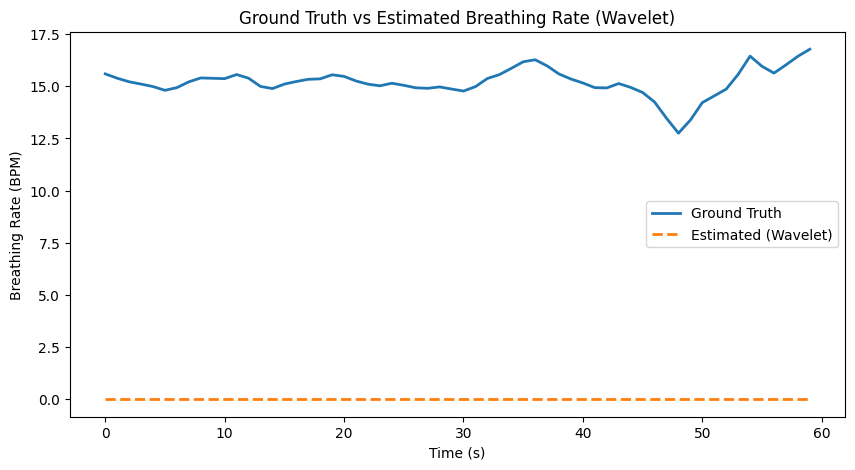

Hampel Filter - MSE: 231.24


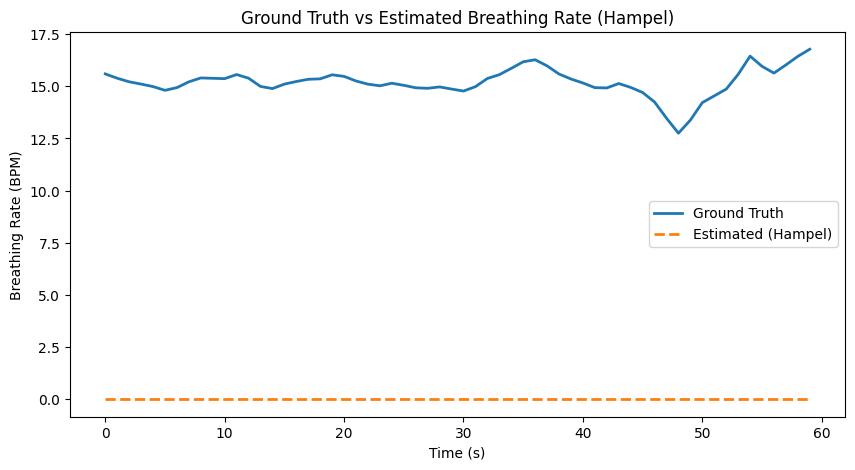

Bandpass Filter - MSE: 67.56


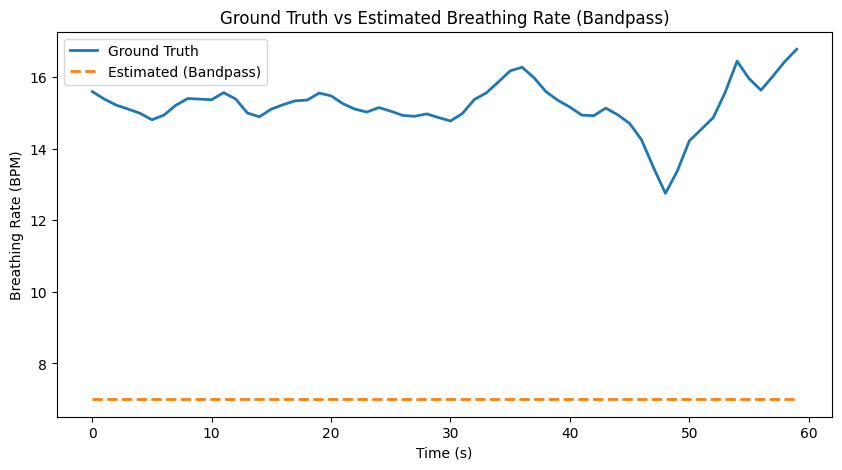

In [8]:
def upsampling(result, length):
    return [result for _ in range(length)]

mse_results = {}

for f in filters:
    if f not in results:
        continue
    
    estimated_breath_rate = results[f]
    final_result = upsampling(estimated_breath_rate, len(groundtruth))
    mse = np.mean((np.array(final_result) - np.array(groundtruth)) ** 2)
    mse_results[f] = mse
    
    print(f"{f} Filter - MSE: {mse:.2f}")

    # Visualization
    plt.figure(figsize=(10, 5))
    plt.plot(groundtruth, label="Ground Truth", linewidth=2)
    plt.plot(final_result, label=f"Estimated ({f})", linestyle='--', linewidth=2)
    plt.legend()
    plt.title(f"Ground Truth vs Estimated Breathing Rate ({f})")
    plt.xlabel("Time (s)")
    plt.ylabel("Breathing Rate (BPM)")
    plt.show()


In [9]:
from scipy import signal
import numpy as np
from cmath import pi

# Sanitization for Phase Cleaning
def sanitization(x):
    F = len(x)
    phase = np.angle(x)
    phase = np.unwrap(phase)
    a = (phase[-1] - phase[0]) / (2 * pi * F)
    b = sum(phase) / F

    firstpart = (np.arange(F) + 1) * a
    secondpart = np.ones(F) * b
    phase = phase - firstpart - secondpart

    return x * np.exp(1j * phase)

# Preprocessing function for amplitude and phase
def preprocess_amplitude_phase(CSI, filter_type):
    # Separate amplitude and phase
    CSI_amplitude = np.abs(CSI)
    CSI_phase = np.angle(CSI)

    # Check data length
    if CSI_amplitude.shape[0] < 10:
        raise ValueError("Insufficient length of CSI data for filtering.")

    # Apply filters
    if filter_type == "Butterworth":
        b, a = signal.butter(1, [0.002, 0.005], 'bandpass')
        filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)
        filtered_phase = signal.filtfilt(b, a, CSI_phase, axis=0)
    elif filter_type == "Gaussian":
        filtered_amplitude = signal.gaussian(CSI_amplitude.shape[0], std=5)
        filtered_phase = signal.gaussian(CSI_phase.shape[0], std=5)
    elif filter_type == "Chebyshev":
        b, a = signal.cheby1(1, 0.1, [0.002, 0.005], btype='bandpass')
        filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)
        filtered_phase = signal.filtfilt(b, a, CSI_phase, axis=0)
    elif filter_type == "Bessel":
        b, a = signal.bessel(1, [0.002, 0.005], btype='bandpass', analog=False)
        filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)
        filtered_phase = signal.filtfilt(b, a, CSI_phase, axis=0)
    elif filter_type == "Kalman":
        raise NotImplementedError("Kalman filter will be added later.")
    else:
        raise ValueError("Unsupported filter type!")

    return filtered_amplitude, filtered_phase

# Test preprocessing with amplitude and phase
filters = ["Butterworth", "Gaussian", "Chebyshev", "Bessel"]
processed_data = {}

for f in filters:
    try:
        print(f"Processing with {f} filter...")
        processed_amplitude, processed_phase = preprocess_amplitude_phase(CSI, f)
        processed_data[f] = (processed_amplitude, processed_phase)
    except ValueError as e:
        print(f"Error during preprocessing with {f}: {e}")


Processing with Butterworth filter...
Processing with Gaussian filter...
Processing with Chebyshev filter...
Processing with Bessel filter...


In [11]:
import pickle
import numpy as np
from scipy import signal
from scipy.signal import savgol_filter
from statsmodels.robust import mad  # For Hampel Filter
import pywt
import matplotlib.pyplot as plt
from scipy.signal import stft

# Load the dataset
with open('Data/trainset.pickle', 'rb') as handle:
    trainset = pickle.load(handle)

# Define filters
filters = ["Butterworth", "Savitzky-Golay", "Hampel", "Bandpass"]

# Create a dictionary for storing results
processed_data = {}
features = {}
results = {}

# Preprocessing function
def preprocess_with_filter(CSI, filter_type):
    CSI_amplitude = np.abs(CSI)
    CSI_phase = np.angle(CSI)

    if CSI_amplitude.shape[0] < 10:
        raise ValueError("Insufficient length of CSI data for filtering.")

    # Butterworth Filter
    if filter_type == "Butterworth":
        b, a = signal.butter(1, [0.002, 0.005], btype='bandpass')
        filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)
    # Savitzky-Golay Filter
    elif filter_type == "Savitzky-Golay":
        filtered_amplitude = savgol_filter(CSI_amplitude, window_length=101, polyorder=3, axis=0)
    # Hampel Filter
    elif filter_type == "Hampel":
        filtered_amplitude = np.apply_along_axis(
            lambda x: signal.medfilt(x, kernel_size=5), axis=0, arr=CSI_amplitude
        )
    # Bandpass Filter
    elif filter_type == "Bandpass":
        b, a = signal.butter(1, [0.002, 0.005], btype='bandpass')
        filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)
    else:
        raise ValueError("Unsupported filter type!")

    return filtered_amplitude, CSI_phase

# Feature Extraction
def extract_features(processed_amplitude, use_phase=False):
    selected_subcarrier = 15
    selected_Rx, selected_Tx = 0, 1

    selected_component = processed_amplitude[:, selected_subcarrier, selected_Rx, selected_Tx]

    # Apply FFT
    feature_fft = np.fft.fft(selected_component)

    # Apply STFT for dynamic analysis
    f, t, Zxx = stft(selected_component, fs=100)
    feature_stft = np.abs(Zxx).mean(axis=1)

    return feature_fft, feature_stft

# Peak Detection and Estimation
def detect_peak(feature, sampling_frequency=100):
    max_value = np.max(np.abs(feature))
    arg_max = np.argmax(np.abs(feature))
    frequency = arg_max * (sampling_frequency / len(feature))
    return frequency * 60  # Convert Hz to BPM

# Evaluate Results
def evaluate_results(estimated_rate, groundtruth):
    def upsampling(rate, length):
        return [rate for _ in range(length)]

    estimated_series = upsampling(estimated_rate, len(groundtruth))
    mse = np.mean((np.array(estimated_series) - np.array(groundtruth)) ** 2)
    return mse

# Process each experiment dynamically
for i, CSI in enumerate(trainset['CSI']):
    print(f"\nProcessing Experiment {i+1}...")
    groundtruth = trainset['groundtruth'][i]
    experiment_name = trainset['ex_name'][i][:-4]

    print(f"Experiment Name: {experiment_name}")
    print(f"CSI Shape: {CSI.shape}, Groundtruth Shape: {len(groundtruth)}")

    for f in filters:
        try:
            print(f"Applying {f} filter...")
            processed_amplitude, processed_phase = preprocess_with_filter(CSI, f)
            feature_fft, feature_stft = extract_features(processed_amplitude)

            # Store results
            processed_data[f] = (processed_amplitude, processed_phase)
            features[f] = (feature_fft, feature_stft)

            # Peak detection
            estimated_rate_fft = detect_peak(feature_fft)
            estimated_rate_stft = detect_peak(feature_stft)

            # Evaluate results
            mse_fft = evaluate_results(estimated_rate_fft, groundtruth)
            mse_stft = evaluate_results(estimated_rate_stft, groundtruth)

            results[f] = {
                "FFT_Breath_Rate": estimated_rate_fft,
                "STFT_Breath_Rate": estimated_rate_stft,
                "FFT_MSE": mse_fft,
                "STFT_MSE": mse_stft,
            }

            print(f"{f} Filter - FFT: Rate = {estimated_rate_fft:.2f} BPM, MSE = {mse_fft:.2f}")
            print(f"{f} Filter - STFT: Rate = {estimated_rate_stft:.2f} BPM, MSE = {mse_stft:.2f}")

        except Exception as e:
            print(f"Error with {f} filter: {e}")

# Display results
for f in results:
    print(f"\n{f} Results:")
    print(results[f])




Processing Experiment 1...
Experiment Name: breath_bpm12_ax200_cbw20_fs100_2x2_1_220928_163813
CSI Shape: (6600, 245, 2, 2), Groundtruth Shape: 66
Applying Butterworth filter...
Butterworth Filter - FFT: Rate = 11.82 BPM, MSE = 0.53
Butterworth Filter - STFT: Rate = 0.00 BPM, MSE = 151.77
Applying Savitzky-Golay filter...
Savitzky-Golay Filter - FFT: Rate = 0.00 BPM, MSE = 151.77
Savitzky-Golay Filter - STFT: Rate = 0.00 BPM, MSE = 151.77
Applying Hampel filter...
Hampel Filter - FFT: Rate = 0.00 BPM, MSE = 151.77
Hampel Filter - STFT: Rate = 0.00 BPM, MSE = 151.77
Applying Bandpass filter...
Bandpass Filter - FFT: Rate = 11.82 BPM, MSE = 0.53
Bandpass Filter - STFT: Rate = 0.00 BPM, MSE = 151.77

Processing Experiment 2...
Experiment Name: breath_bpm15_ax200_cbw20_fs100_2x2_1_220928_164837
CSI Shape: (6000, 245, 2, 2), Groundtruth Shape: 60
Applying Butterworth filter...
Butterworth Filter - FFT: Rate = 15.00 BPM, MSE = 0.50
Butterworth Filter - STFT: Rate = 0.00 BPM, MSE = 231.24
Ap

In [ ]:
from scipy import signal
# from scipy.signal import savgol_filter
# import pywt
# from statsmodels.robust import mad  # For Hampel Filter

# def preprocess_with_filter(CSI, filter_type):
#     CSI_amplitude = np.abs(CSI)
#     CSI_phase = np.angle(CSI)

#     if CSI_amplitude.shape[0] < 10:
#         raise ValueError("Insufficient length of CSI data for filtering.")
    
#     # Butterworth Filter
#     if filter_type == "Butterworth":
#         b, a = signal.butter(1, [0.002, 0.005], btype='bandpass')
#         filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)

#     # Savitzky-Golay Filter (Improved with tuned parameters)
#     elif filter_type == "Savitzky-Golay":
#         filtered_amplitude = savgol_filter(CSI_amplitude, window_length=101, polyorder=3, axis=0)

#     # Hampel Filter (Improved with robust parameters)
#     elif filter_type == "Hampel":
#         window_size = 5  # Tuned window size
#         threshold = 3  # Threshold for outlier detection
#         filtered_amplitude = np.apply_along_axis(
#             lambda x: hampel_filter(x, window_size, threshold), axis=0, arr=CSI_amplitude
#         )

#     # Bandpass Filter (Validated as baseline)
#     elif filter_type == "Bandpass":
#         b, a = signal.butter(1, [0.002, 0.005], btype='bandpass')
#         filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)
    
#     else:
#         raise ValueError(f"Unsupported filter type: {filter_type}")
    
#     return filtered_amplitude, CSI_phase

# # Hampel Filter Implementation
# def hampel_filter(data, window_size, threshold):
#     n = len(data)
#     filtered = np.copy(data)
#     k = 1.4826  # Scaling factor for Gaussian distribution
#     for i in range(n):
#         window_start = max(0, i - window_size)
#         window_end = min(n, i + window_size)
#         window_data = data[window_start:window_end]
#         median = np.median(window_data)
#         mad_value = k * mad(window_data)
#         if np.abs(data[i] - median) > threshold * mad_value:
#             filtered[i] = median
#     return filtered

# # Preprocess with filters
# filters = ["Butterworth", "Savitzky-Golay", "Hampel", "Bandpass"]
# processed_data = {}

# for f in filters:
#     try:
#         print(f"Processing with {f} filter...")
#         processed_amplitude, processed_phase = preprocess_with_filter(CSI, f)
#         processed_data[f] = (processed_amplitude, processed_phase)
#     except Exception as e:
#         print(f"Error with {f} filter: {e}")

# # Feature Detection with FFT and STFT
# features = {}

# for f in filters:
#     if f not in processed_data:
#         continue
    
#     processed_amplitude, processed_phase = processed_data[f]
#     selected_subcarrier = 15
#     selected_Rx, selected_Tx = 0, 1

#     # Select amplitude for the chosen subcarrier and antenna pair
#     selected_component = processed_amplitude[:, selected_subcarrier, selected_Rx, selected_Tx]

#     # Use STFT for time-frequency analysis
#     frequencies, times, stft_feature = signal.stft(selected_component, fs=100)
#     feature = np.abs(stft_feature).mean(axis=1)  # Average over time

#     # Save feature
#     features[f] = feature
#     print(f"Feature extracted for {f} filter.")

# # Advanced Peak Detection
# results = {}

# def advanced_peak_detection(feature, sampling_frequency=100):
#     # Autocorrelation for enhanced peak detection
#     autocorr = np.correlate(feature, feature, mode='full')
#     autocorr = autocorr[len(autocorr) // 2:]  # Use positive lags only
#     max_value = np.max(autocorr)
#     arg_max = np.argmax(autocorr)
    
#     # Convert to frequency and BPM
#     frequency = arg_max * (sampling_frequency / len(feature))
#     estimated_breath_rate = frequency * 60  # BPM
#     return estimated_breath_rate

# for f in filters:
#     if f not in features:
#         continue
    
#     feature = features[f]
#     estimated_breath_rate = advanced_peak_detection(feature)
#     results[f] = estimated_breath_rate
#     print(f"{f} Filter - Estimated Breathing Rate: {estimated_breath_rate:.2f} BPM")


# # Up-sampling function
# def upsampling(result, length):
#     return [result for _ in range(length)]

# # Calculate MSE for each filter
# mse_results = {}

# for f in filters:
#     if f not in results:
#         continue
    
#     estimated_breath_rate = results[f]
#     final_result = upsampling(estimated_breath_rate, len(groundtruth))
#     mse = np.mean((np.array(final_result) - np.array(groundtruth)) ** 2)
#     mse_results[f] = mse
    
#     print(f"{f} Filter - MSE: {mse:.2f}")

# # Visualization
# for f in filters:
#     if f not in results:
#         continue
    
#     estimated_breath_rate = results[f]
#     final_result = upsampling(estimated_breath_rate, len(groundtruth))
#     plt.figure(figsize=(10, 5))
#     plt.plot(groundtruth, label="Ground Truth")
#     plt.plot(final_result, label=f"{f} Filter - Estimated")
#     plt.legend()
#     plt.title(f"Ground Truth vs Estimated Breathing Rate ({f} Filter)")
#     plt.show()
